# Author's Notes

May 2021 Update: We now generate tab-delimited files (TSVs) for each clustering algo. You can load the first three dimensions along with the labels in [Tensorboard Projector](https://projector.tensorflow.org) to visualize the group segmentation in 3-D space.

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 6 - Group Segmentation

# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning-master/")

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/github/handson-unsupervised-learning-master


In [2]:
# Install additional libraries
!pip install fastcluster==1.1.26
!pip install hdbscan==0.8.27

# Import Libraries

In [3]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn import impute
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# Load & Prepare Data

In [4]:
# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'lending_club_data', 'LoanStats3a.csv'])
data = pd.read_csv(current_path + file, low_memory=False)

In [5]:
# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]

In [6]:
# View shape
data.shape

(42542, 37)

In [7]:
# Preview data
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [8]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

In [9]:
# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

In [10]:
# Display NaNs by feature
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [11]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = impute.SimpleImputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [12]:
# Check for NaNs one last time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [13]:
# Feature engineering
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

In [14]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [15]:
# View columns
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

In [16]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [17]:
# Fill missing labels
labels = labels.fillna(value="Z")

# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name="grade")

# Store as y_train
y_train = labels

In [18]:
# Show numerical labels
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B
...,...,...
42537,0,A
42538,7,NaN
42539,7,NaN
42540,7,NaN


In [19]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,734.270844
1.0,1101.420857
2.0,1349.988902
3.0,1557.714927
4.0,1737.676783
5.0,1926.530361
6.0,2045.125000
7.0,1216.501563


# Define Function

In [20]:
# To Analyze Goodness of the Clusters
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
        left_on="cluster",right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
        accuracyDF, overallAccuracy, accuracyByLabel

##PCA &Hierarchical Clustering Application

In [21]:
import seaborn as sns
sns.set()

In [22]:
import numpy as np

Y = np.zeros((35,2))


In [23]:
# Principal Component Analysis
from sklearn.decomposition import PCA
for i in range(1,35):
      n_components = i
      whiten = False
      random_state = 2018

      pca = PCA(n_components=n_components, whiten=whiten, \
                random_state=random_state)

      X_train_PCA = pca.fit_transform(X_train)
      X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)


      # Hierarchical Clustering Application
      import fastcluster
      from scipy.cluster.hierarchy import dendrogram
      from scipy.cluster.hierarchy import cophenet
      from scipy.spatial.distance import pdist

      Z = fastcluster.linkage_vector(X_train_PCA, method='ward', \
                                    metric='euclidean')

      Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne', \
                      'clusterTwo','distance','newClusterSize'])

      # Cluster results
      from scipy.cluster.hierarchy import fcluster

      distance_threshold = 100
      clusters = fcluster(Z, distance_threshold, criterion='distance')
      X_train_hierClustered = pd.DataFrame(data=clusters, \
          index=X_train.index,columns=['cluster'])
      Y[i,0]= len(X_train_hierClustered['cluster'].unique())
      # Show number of clusters created
      print("Number of distinct clusters: ", \
          Y[i,0])

      # Show overall accuracy
      countByCluster_hierClust, countByLabel_hierClust, \
          countMostFreq_hierClust, accuracyDF_hierClust, \
          overallAccuracy_hierClust, accuracyByLabel_hierClust = \
          analyzeCluster(X_train_hierClustered, y_train)
      Y[i,1] = overallAccuracy_hierClust
      print("Overall accuracy from hierarchical clustering: ", \
           Y[i,1] )

Number of distinct clusters:  7.0
Overall accuracy from hierarchical clustering:  0.3116919749894222
Number of distinct clusters:  11.0
Overall accuracy from hierarchical clustering:  0.31136288843965965
Number of distinct clusters:  15.0
Overall accuracy from hierarchical clustering:  0.3359503549433501
Number of distinct clusters:  19.0
Overall accuracy from hierarchical clustering:  0.3509472991396737
Number of distinct clusters:  21.0
Overall accuracy from hierarchical clustering:  0.3367730713177566
Number of distinct clusters:  19.0
Overall accuracy from hierarchical clustering:  0.33776033096704433
Number of distinct clusters:  23.0
Overall accuracy from hierarchical clustering:  0.36462789713694704
Number of distinct clusters:  23.0
Overall accuracy from hierarchical clustering:  0.370222368482911
Number of distinct clusters:  25.0
Overall accuracy from hierarchical clustering:  0.36204221710309814
Number of distinct clusters:  25.0
Overall accuracy from hierarchical clustering

Text(0.5, 1.0, 'Overall accuracy and Number of Principal component')

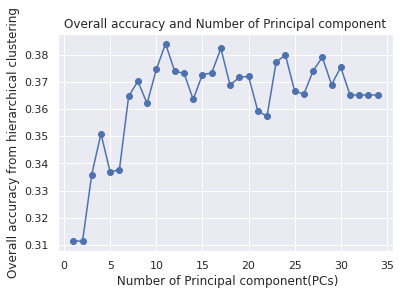

In [35]:
PCs = np.arange(1,35)
plt.plot(PCs,Y[1:,1])
plt.scatter(PCs,Y[1:,1])
plt.ylabel('Overall accuracy from hierarchical clustering')
plt.xlabel(' Number of Principal component(PCs)')
plt.title('Overall accuracy and Number of Principal component')

Text(0.5, 1.0, 'Number of distinct clusters and Number of Principal component')

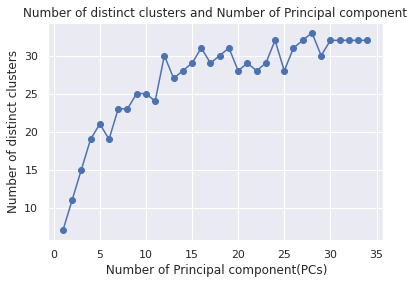

In [37]:
PCs = np.arange(1,35)
plt.plot(PCs,Y[1:,0])
plt.scatter(PCs,Y[1:,0])
plt.ylabel('Number of distinct clusters')
plt.xlabel(' Number of Principal component(PCs)')
plt.title('Number of distinct clusters and Number of Principal component')